# Alphalens Factor Analysis

This notebook demonstrates how to use Alphalens to analyze factor performance:
- Test if a factor predicts future returns
- Analyze factor returns across quantiles
- Measure information coefficient (IC)
- Evaluate factor turnover and decay

Alphalens is the industry-standard tool for quantitative factor research.

## Prerequisites

```bash
pip install alphalens-reloaded
```

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import Alphalens
try:
    import alphalens as al
    print("✓ Alphalens imported")
except ImportError:
    print("⚠️  Alphalens not installed")
    print("   Install with: pip install alphalens-reloaded")
    raise

from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume
from zipline.data.bundles import load
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader

plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('darkgrid')

print("✓ Imports complete")

✓ Alphalens imported
✓ Imports complete


## Setup Pipeline Environment

In [3]:
# Load bundle and create pipeline engine
bundle_data = load('sharadar')
trading_calendar = get_calendar('XNYS')

pricing_loader = USEquityPricingLoader.without_fx(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

engine = SimplePipelineEngine(
    get_loader=lambda column: pricing_loader,
    asset_finder=bundle_data.asset_finder,
)

print("✓ Pipeline engine initialized")

✓ Pipeline engine initialized


## Define Research Factor: Momentum

We'll test a momentum factor to see if it predicts future returns.

In [4]:
class Momentum(CustomFactor):
    """
    Price momentum: % return over lookback period.
    
    This is our alpha factor we want to test.
    """
    inputs = [USEquityPricing.close]
    window_length = 60  # 60-day momentum
    
    def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]


def make_momentum_pipeline():
    """
    Create a pipeline that computes momentum for liquid stocks.
    """
    # Calculate momentum
    momentum = Momentum()
    
    # Universe: top 500 liquid stocks
    dollar_volume = AverageDollarVolume(window_length=30)
    universe = dollar_volume.top(500)
    
    return Pipeline(
        columns={
            'momentum': momentum,
        },
        screen=universe
    )

print("✓ Momentum factor defined")

✓ Momentum factor defined


## Run Pipeline to Get Factor Data

Compute the momentum factor for all stocks over our research period.

In [5]:
# Define research period (need enough data for forward returns)
# Ensure dates are valid trading days
all_sessions = trading_calendar.sessions

desired_start = pd.Timestamp('2022-01-01')
desired_end = pd.Timestamp('2023-06-30')

# Get first trading day on or after desired start
start_date = all_sessions[all_sessions >= desired_start][0]
# Get last trading day on or before desired end
end_date = all_sessions[all_sessions <= desired_end][-1]

print(f"Running pipeline from {start_date.date()} to {end_date.date()}...")
print(f"  (Adjusted to valid trading days)")

pipeline = make_momentum_pipeline()
factor_data = engine.run_pipeline(pipeline, start_date, end_date)

print(f"\n✓ Pipeline complete")
print(f"  Observations: {len(factor_data):,}")
print(f"  Unique stocks: {factor_data.index.get_level_values(1).nunique()}")
print(f"  Trading days: {factor_data.index.get_level_values(0).nunique()}")

factor_data.head()

Running pipeline from 2022-01-03 to 2023-06-30...
  (Adjusted to valid trading days)

✓ Pipeline complete
  Observations: 187,500
  Unique stocks: 823
  Trading days: 375


momentum
2022-01-03 Equity(110168 [ETHE])  -0.057933
           Equity(110316 [BILL])  -0.103745
           Equity(110406 [SICPQ]) -0.023201
           Equity(110495 [BNTX])   0.045548
           Equity(110518 [PTON])  -0.592432

## Get Pricing Data for Alphalens

Alphalens needs pricing data to compute forward returns.

In [6]:
# Get all unique assets from factor data
assets = factor_data.index.get_level_values(1).unique()

# Get pricing data (need extra days for forward returns)
# Find a valid pricing end date ~30 days after end_date
pricing_start = start_date
pricing_end = all_sessions[all_sessions > end_date][29]  # ~30 trading days later

# Get pricing from bundle
pricing_data = bundle_data.equity_daily_bar_reader.load_raw_arrays(
    columns=['close'],
    start_date=pricing_start,
    end_date=pricing_end,
    assets=assets,
)

# Convert to DataFrame
dates = trading_calendar.sessions_in_range(pricing_start, pricing_end)
prices = pd.DataFrame(
    data=pricing_data[0],  # Already in correct shape (dates, assets), no transpose needed
    index=dates,
    columns=assets
)

print(f"✓ Pricing data loaded")
print(f"  Shape: {prices.shape}")
print(f"  Date range: {prices.index.min()} to {prices.index.max()}")

prices.head()

✓ Pricing data loaded
  Shape: (405, 823)
  Date range: 2022-01-03 00:00:00 to 2023-08-14 00:00:00


,Equity(110168 [ETHE]),Equity(110316 [BILL]),Equity(110406 [SICPQ]),Equity(110495 [BNTX]),Equity(110518 [PTON]),Equity(110534 [DDOG]),Equity(110553 [NET]),Equity(110595 [CHPT]),Equity(110723 [CHWY]),Equity(110725 [CRWD]),...,Equity(635375 [MNDY]),Equity(197070 [NRG]),Equity(196236 [EG]),Equity(632424 [QQQM]),Equity(110612 [DT]),Equity(194996 [CE]),Equity(187740 [SYNH]),Equity(196000 [NDAQ]),Equity(198289 [COHR]),Equity(191005 [ICLR])
2022-01-03,32.37,233.54,148.98,228.800,35.20,163.83,126.16,397.4,57.48,198.33,...,301.21,38.372,253.746,161.050,59.30,156.315,99.36,64.008,71.53,296.03
2022-01-04,33.72,218.42,150.61,221.142,33.82,157.76,114.96,390.4,54.40,189.19,...,289.26,38.068,253.820,158.935,56.29,160.692,94.38,62.405,74.49,287.97
2022-01-05,30.32,202.29,136.31,208.649,32.23,145.52,105.95,363.2,52.01,179.29,...,249.00,36.996,250.453,154.140,53.71,162.223,93.81,61.656,72.40,279.28
2022-01-06,28.81,202.90,132.34,211.915,33.86,143.89,104.04,347.0,52.89,187.49,...,241.10,36.299,255.160,153.954,53.79,160.254,95.30,61.795,71.72,285.64
2022-01-07,26.72,201.93,128.49,209.053,35.58,143.79,107.00,337.8,48.52,188.99,...,237.38,36.228,259.680,152.307,54.05,160.590,91.80,61.178,71.79,280.68


## Prepare Data for Alphalens

Alphalens requires a specific format: MultiIndex Series with (date, asset) and aligned pricing.

In [7]:
# Extract factor as Series
factor = factor_data['momentum']

# Get alphalens format (computes forward returns automatically)
factor_data_clean = al.utils.get_clean_factor_and_forward_returns(
    factor=factor,
    prices=prices,
    quantiles=5,  # Divide into 5 quintiles
    periods=(1, 5, 10),  # Forward returns: 1, 5, 10 days
    max_loss=0.35,  # Allow up to 35% data loss (for missing data)
)

print("✓ Factor data prepared for Alphalens")
print(f"  Clean observations: {len(factor_data_clean):,}")
print(f"\nColumns:")
for col in factor_data_clean.columns:
    print(f"  - {col}")

factor_data_clean.head()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
✓ Factor data prepared for Alphalens
  Clean observations: 187,414

Columns:
  - 1D
  - 5D
  - 10D
  - factor
  - factor_quantile


1D        5D       10D    factor  \
date       asset                                                            
2022-01-03 Equity(110168 [ETHE])   0.041705 -0.193698 -0.218103 -0.057933   
           Equity(110316 [BILL])  -0.064743 -0.139377 -0.254903 -0.103745   
           Equity(110406 [SICPQ])  0.010941 -0.172238 -0.306350 -0.023201   
           Equity(110495 [BNTX])  -0.033470 -0.007981 -0.270087  0.045548   
           Equity(110518 [PTON])  -0.039205 -0.023580 -0.141193 -0.592432   

                                   factor_quantile  
date       asset                                    
2022-01-03 Equity(110168 [ETHE])                 2  
           Equity(110316 [BILL])                 1  
           Equity(110406 [SICPQ])                2  
           Equity(110495 [BNTX])                 3  
           Equity(110518 [PTON])                 1

## Alphalens Analysis: Full Tearsheet

Generate comprehensive factor analysis including:
- Returns Analysis
- Information Coefficient (IC)
- Turnover Analysis
- Quantile Analysis

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.976122,0.014557,-0.245203,0.146013,37500,20.009178
2,-0.305090,0.095361,-0.079020,0.070776,37479,19.997972
3,-0.194495,0.166112,-0.015052,0.062560,37456,19.985700
4,-0.128667,0.283639,0.051568,0.066261,37479,19.997972
5,-0.043341,18.158879,0.261159,0.340876,37500,20.009178


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.126,-0.129,-0.115
beta,-0.465,-0.356,-0.346
Mean Period Wise Return Top Quantile (bps),-4.827,-5.136,-4.245
Mean Period Wise Return Bottom Quantile (bps),1.711,2.560,1.471
Mean Period Wise Spread (bps),-6.538,-7.347,-5.434


<Figure size 1400x800 with 0 Axes>

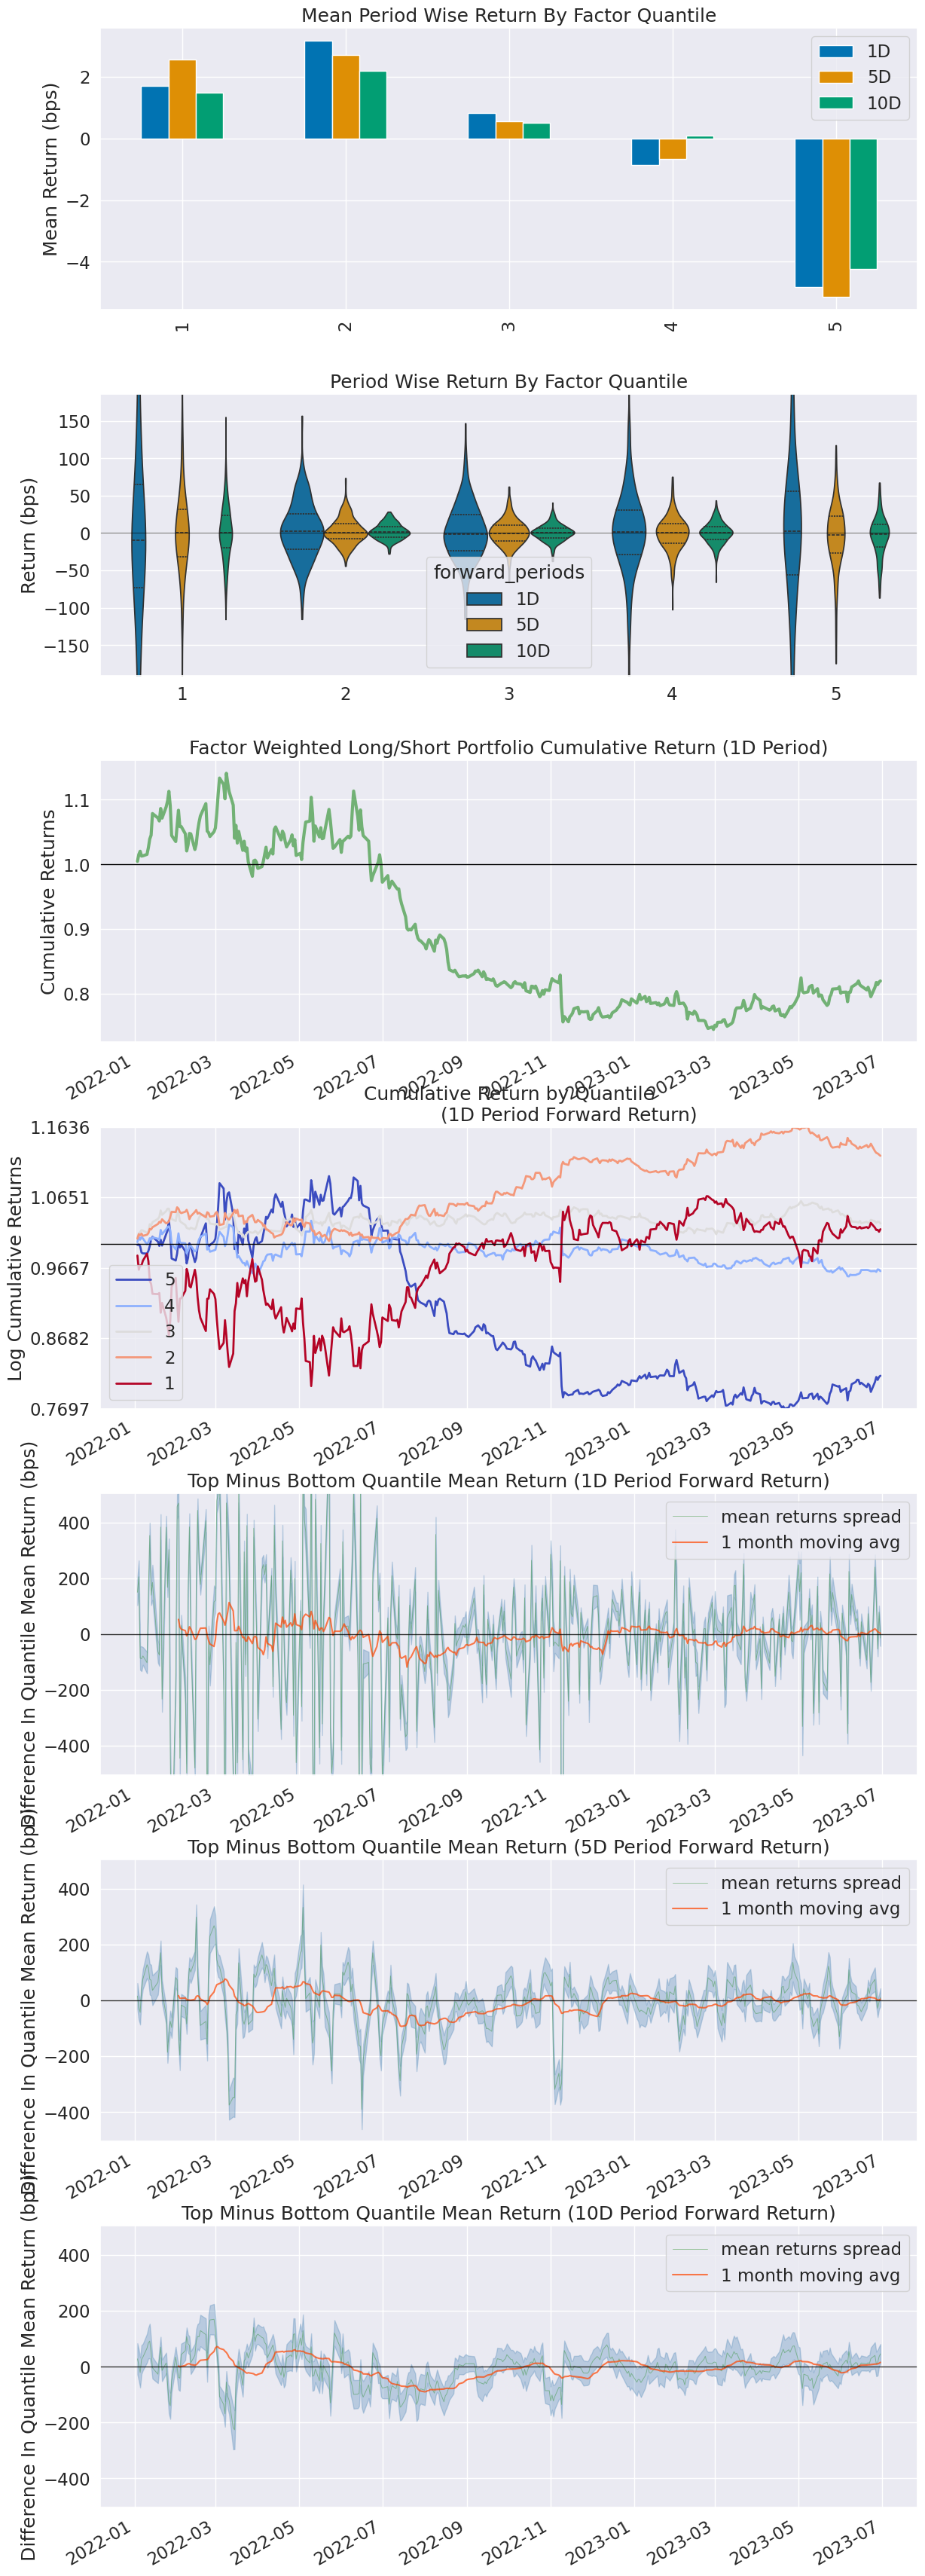

Information Analysis


,1D,5D,10D
IC Mean,0.004,-0.018,-0.025
IC Std.,0.301,0.258,0.244
Risk-Adjusted IC,0.014,-0.068,-0.103
t-stat(IC),0.268,-1.317,-2.000
p-value(IC),0.789,0.189,0.046
IC Skew,-0.284,-0.193,-0.009
IC Kurtosis,-0.318,-0.125,-0.366


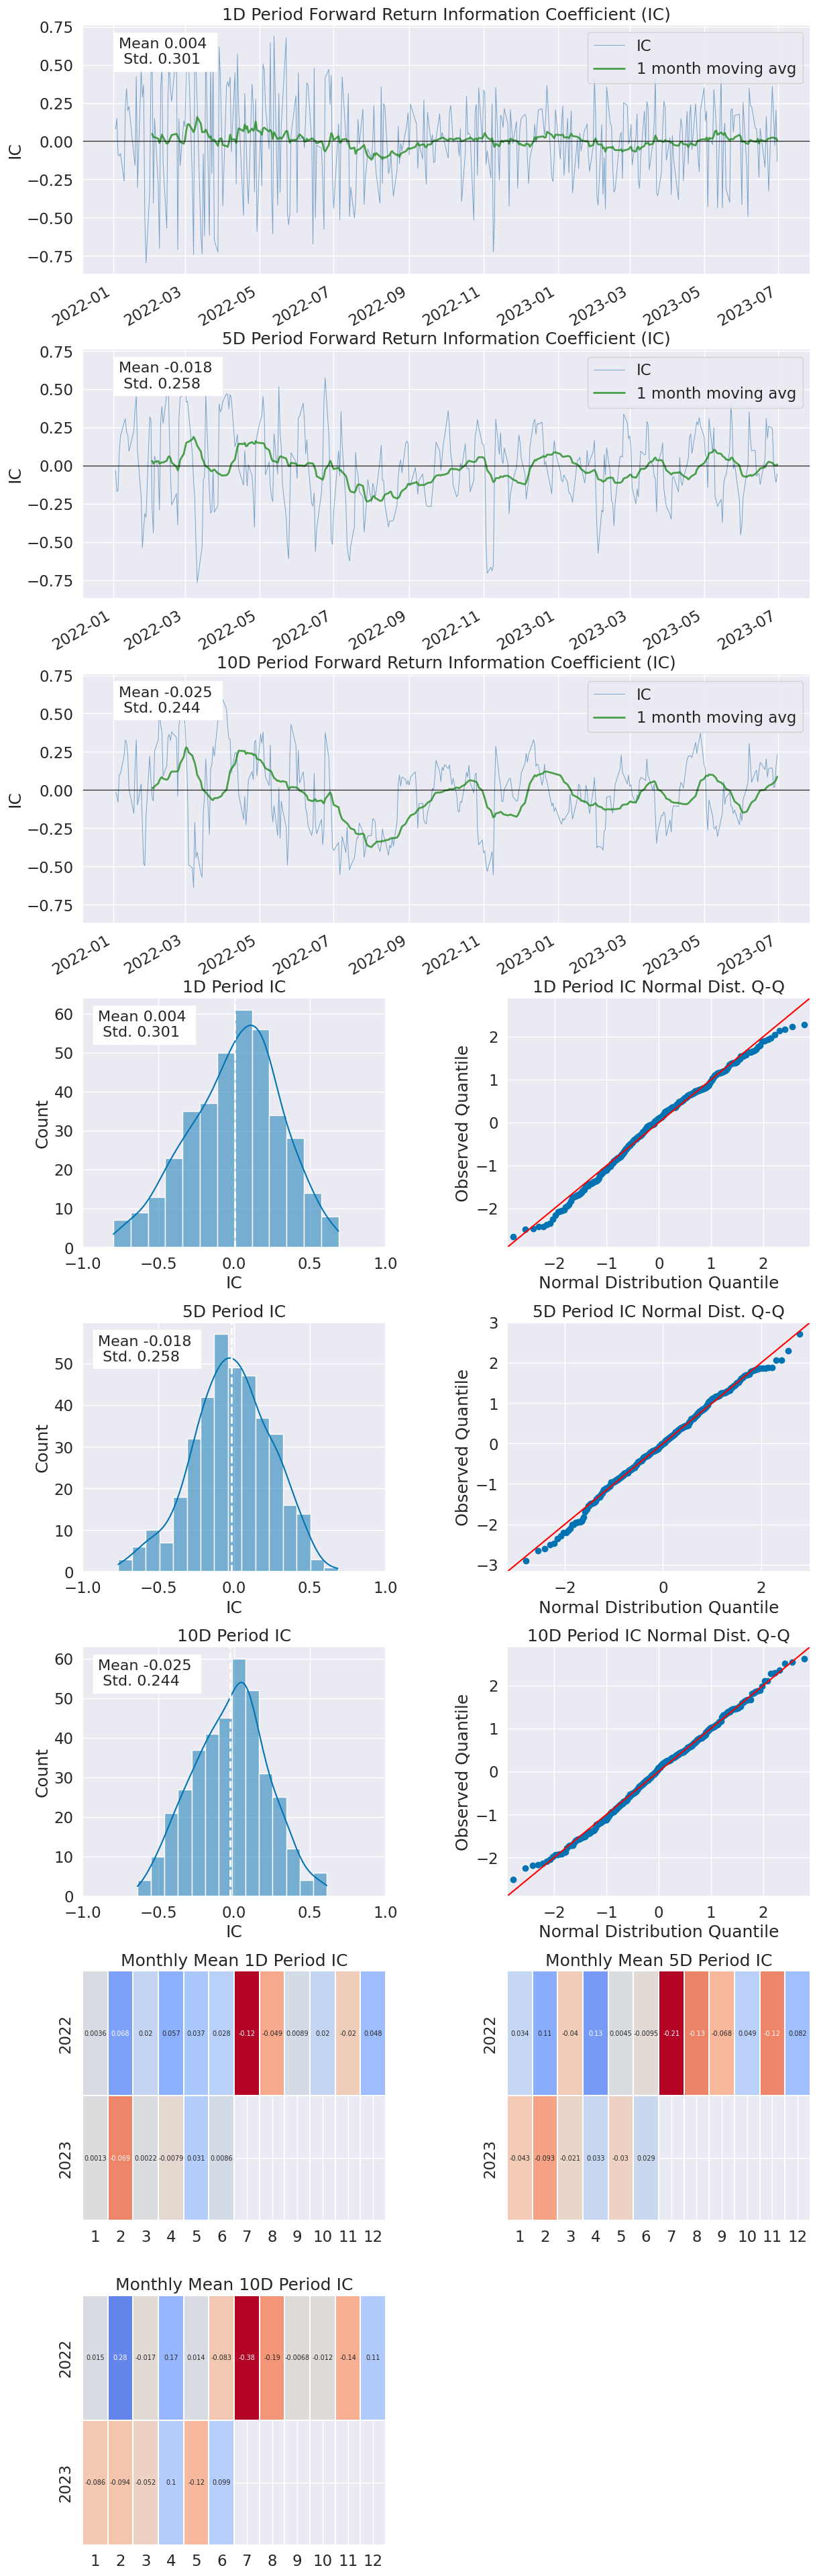

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.093,0.222,0.317
Quantile 2 Mean Turnover,0.219,0.440,0.552
Quantile 3 Mean Turnover,0.258,0.474,0.568
Quantile 4 Mean Turnover,0.225,0.454,0.568
Quantile 5 Mean Turnover,0.099,0.242,0.347


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.975,0.884,0.79


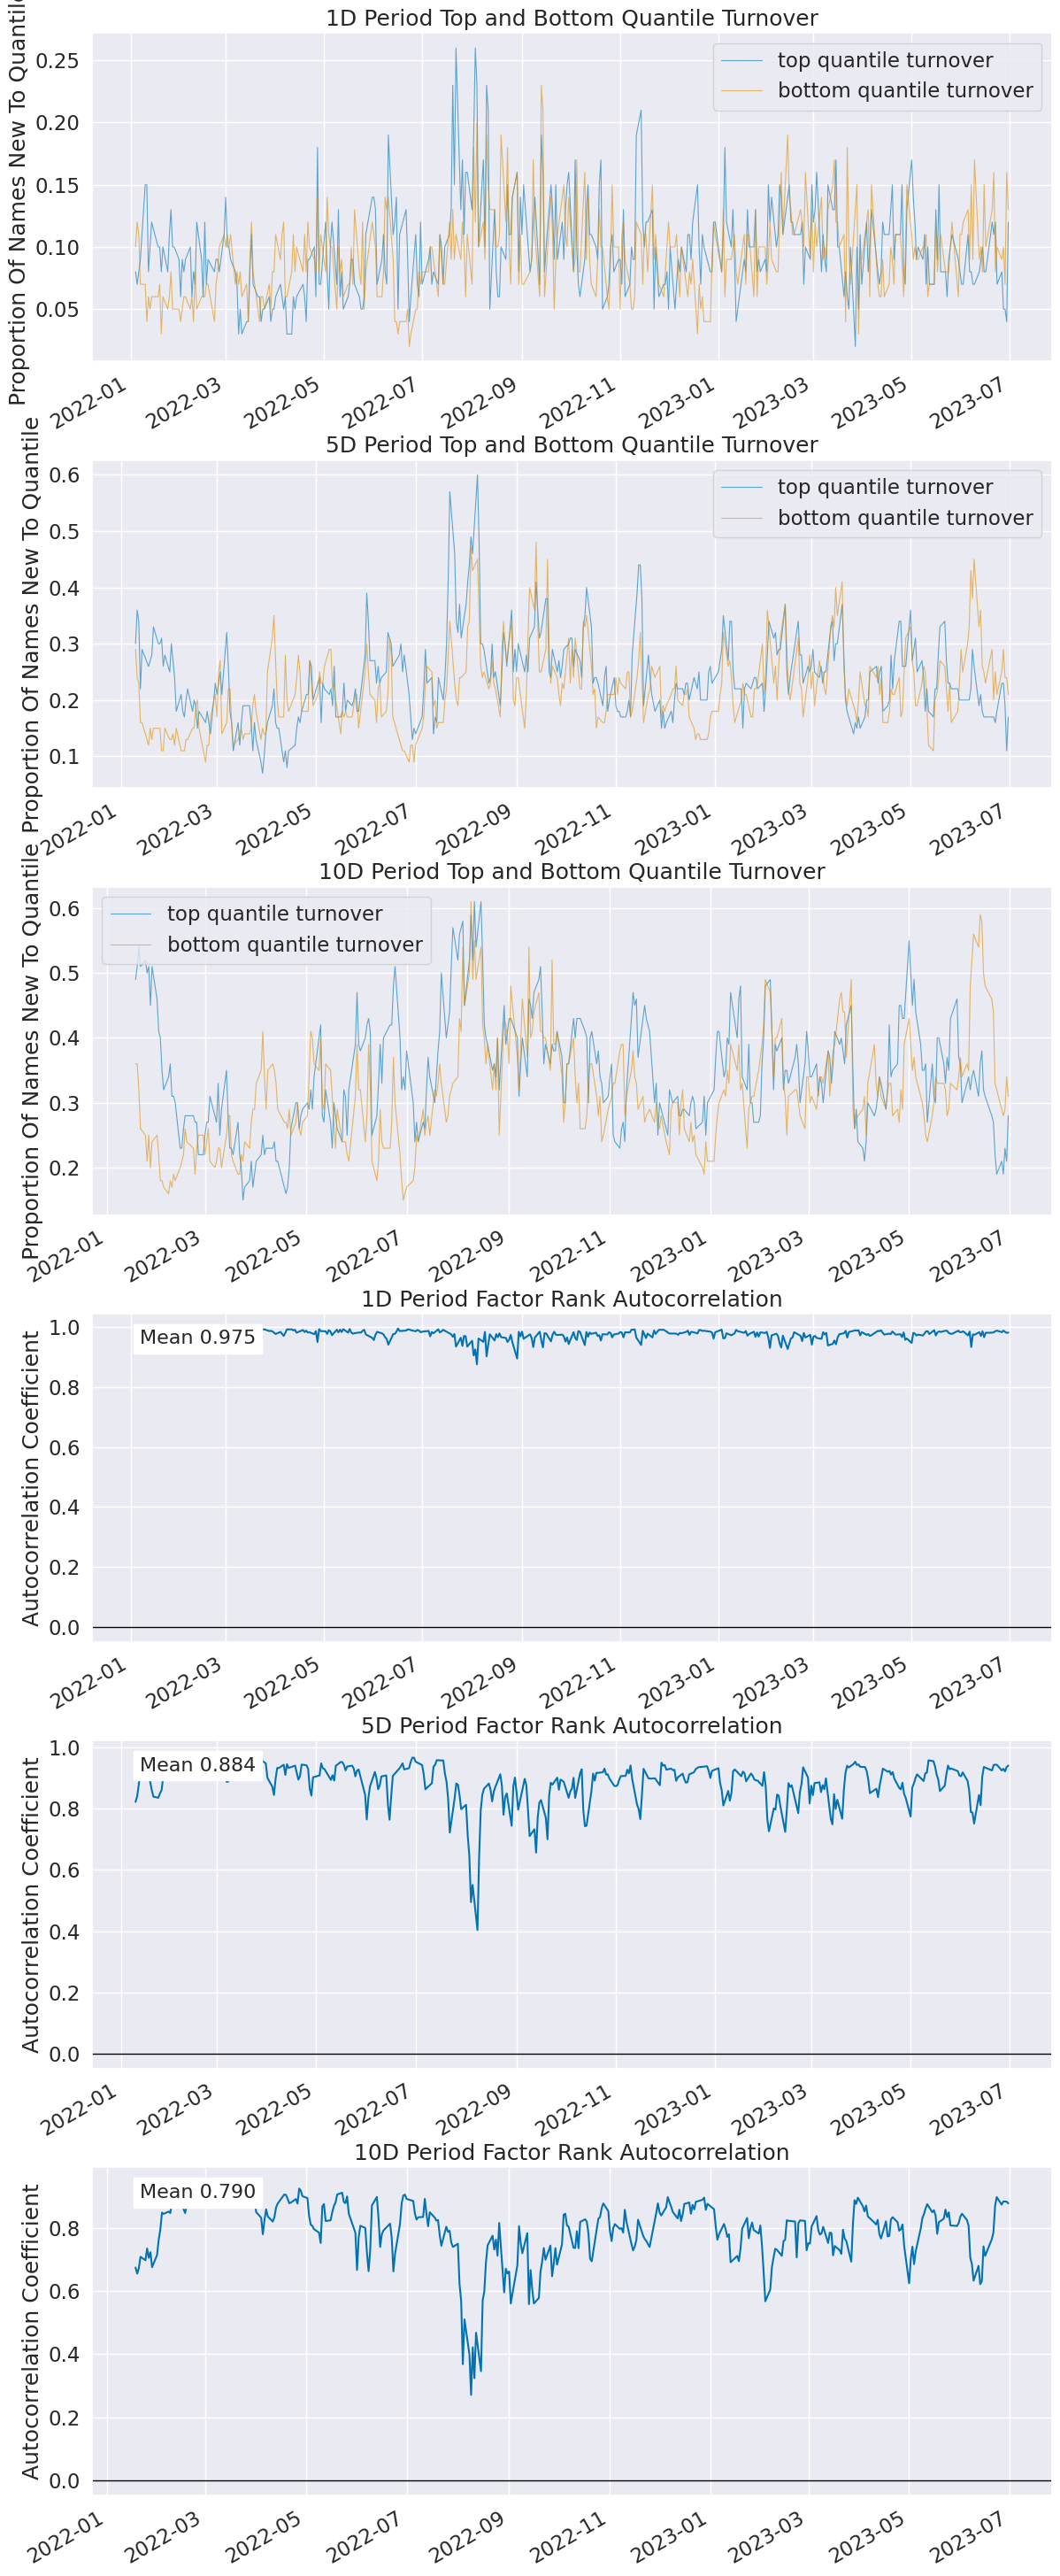

In [8]:
# Create full tearsheet
al.tears.create_full_tear_sheet(factor_data_clean)

## Interpretation Guide

### Key Metrics to Look For:

**1. Returns by Quantile**
- Does the top quantile (Q5) outperform the bottom (Q1)?
- Is there a monotonic relationship (Q1 < Q2 < Q3 < Q4 < Q5)?

**2. Information Coefficient (IC)**
- **IC > 0.05**: Good predictive power
- **IC > 0.10**: Strong predictive power
- **IC < 0**: Factor might be reversed

**3. IC Over Time**
- Is IC stable or does it decay?
- Are there regime changes?

**4. Turnover**
- High turnover = More trading costs
- Lower is better for practical implementation

**5. Factor Returns**
- Cumulative returns of top vs bottom quantile
- Sharpe ratio of factor returns

## Custom Analysis: Quantile Returns

In [9]:
# Calculate mean returns by quantile
mean_returns = factor_data_clean.groupby('factor_quantile')[['1D', '5D', '10D']].mean()

print("\nMean Forward Returns by Momentum Quantile:")
print("="*60)
print(mean_returns)
print("\n")

# Calculate spread (Q5 - Q1)
spread = mean_returns.loc[5] - mean_returns.loc[1]
print("Spread (Q5 - Q1):")
print(spread)
print("\nA positive spread means the factor is predictive!")


Mean Forward Returns by Momentum Quantile:
                       1D        5D       10D
factor_quantile                              
1               -0.000026  0.000398 -0.000066
2                0.000121  0.000470  0.000656
3               -0.000115 -0.000600 -0.001014
4               -0.000282 -0.001215 -0.001446
5               -0.000680 -0.003448 -0.005775


Spread (Q5 - Q1):
1D    -0.000654
5D    -0.003846
10D   -0.005709
dtype: float64

A positive spread means the factor is predictive!


## Information Coefficient Analysis


Information Coefficient (IC) Statistics:
               1D          5D         10D
count  375.000000  375.000000  375.000000
mean     0.004166   -0.017570   -0.025159
std      0.301128    0.258288    0.243637
min     -0.796216   -0.764775   -0.637503
25%     -0.202284   -0.185667   -0.196744
50%      0.032470   -0.016934   -0.004508
75%      0.213289    0.161818    0.135171
max      0.687984    0.684081    0.610676


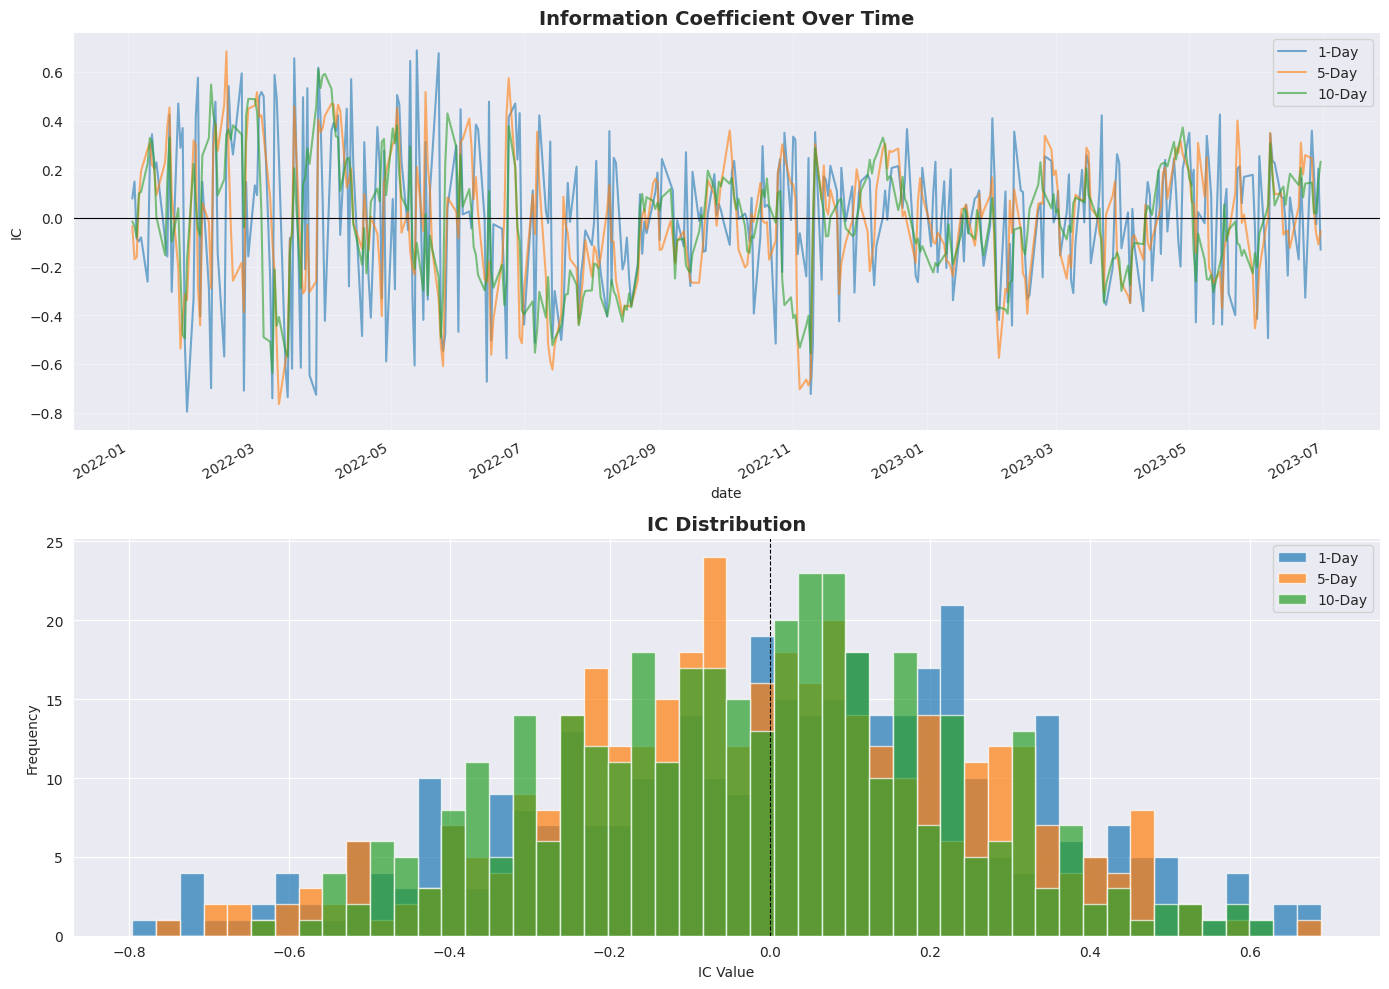

In [10]:
# Calculate IC for each period
ic = al.performance.factor_information_coefficient(factor_data_clean)

print("\nInformation Coefficient (IC) Statistics:")
print("="*60)
print(ic.describe())

# Plot IC over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# IC time series
ic.plot(ax=axes[0], alpha=0.6)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_title('Information Coefficient Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('IC')
axes[0].legend(['1-Day', '5-Day', '10-Day'])
axes[0].grid(True, alpha=0.3)

# IC distribution
ic.plot(kind='hist', bins=50, ax=axes[1], alpha=0.7)
axes[1].set_title('IC Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('IC Value')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].legend(['1-Day', '5-Day', '10-Day'])

plt.tight_layout()
plt.show()

## Factor Returns Analysis

Analyze the returns you would get from going long the top quantile and short the bottom.

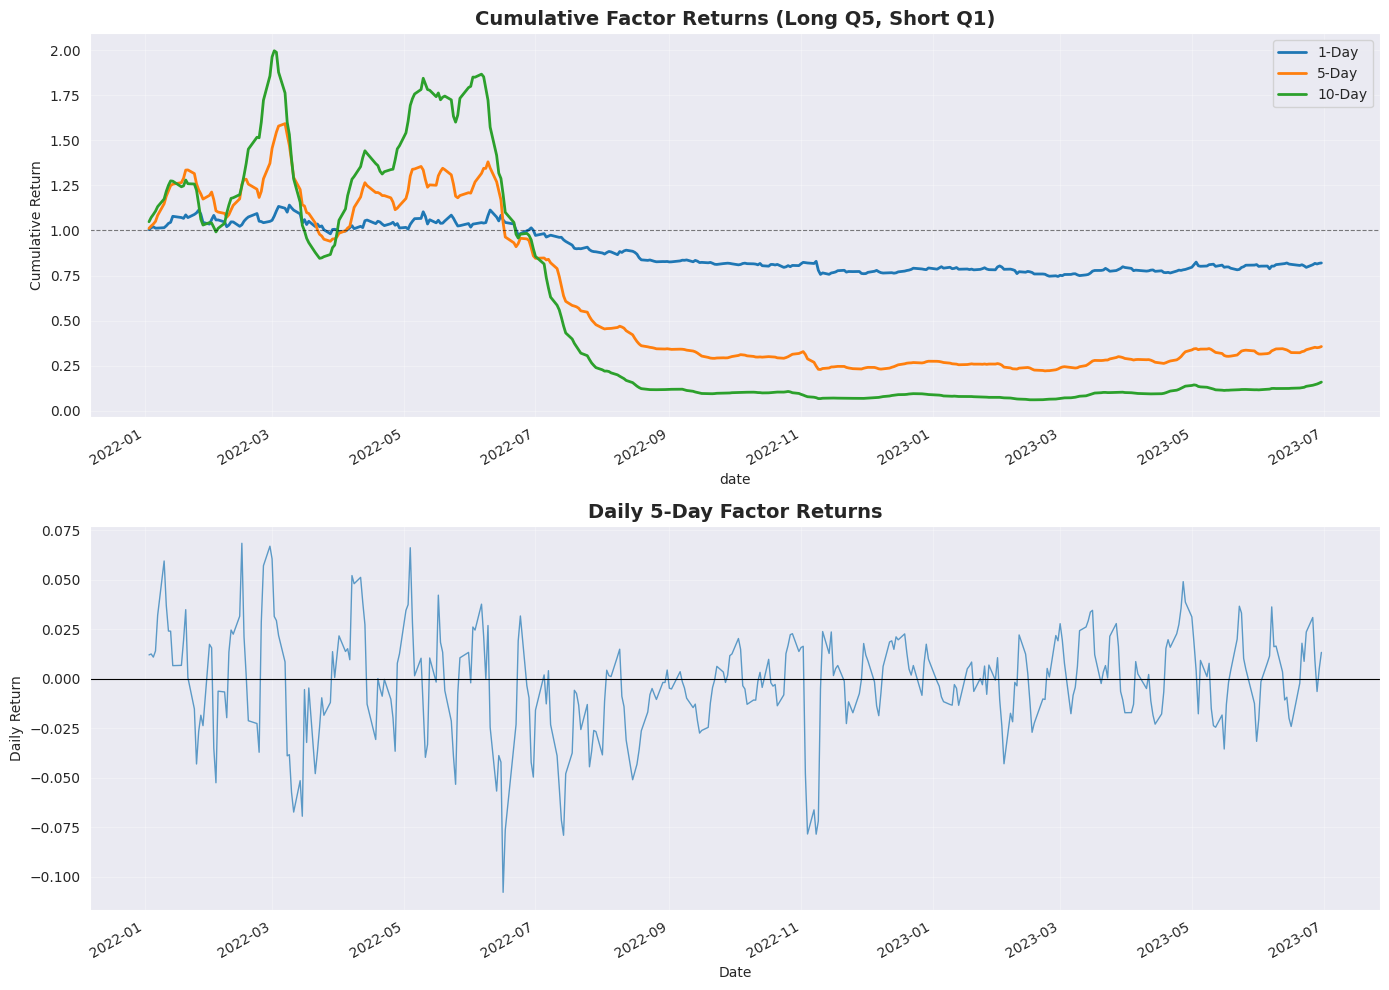


Factor Sharpe Ratios:
1D    -0.534923
5D    -1.482175
10D   -1.990816
dtype: float64


In [11]:
# Calculate factor returns (long-short portfolio)
factor_returns = al.performance.factor_returns(factor_data_clean)

# Calculate cumulative returns
cumulative_returns = (1 + factor_returns).cumprod()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative factor returns
cumulative_returns.plot(ax=axes[0], linewidth=2)
axes[0].set_title('Cumulative Factor Returns (Long Q5, Short Q1)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].axhline(1, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].legend(['1-Day', '5-Day', '10-Day'])
axes[0].grid(True, alpha=0.3)

# Daily factor returns
factor_returns['5D'].plot(ax=axes[1], linewidth=1, alpha=0.7)
axes[1].set_title('Daily 5-Day Factor Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Daily Return')
axes[1].set_xlabel('Date')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate Sharpe ratios
sharpe_ratios = factor_returns.mean() / factor_returns.std() * np.sqrt(252)
print("\nFactor Sharpe Ratios:")
print(sharpe_ratios)

## Summary Statistics

In [12]:
# Calculate key metrics
print("\n" + "="*80)
print("FACTOR ANALYSIS SUMMARY")
print("="*80)

# Mean IC
mean_ic = ic.mean()
print("\nMean Information Coefficient:")
print(mean_ic)

# IC t-stat
ic_tstat = ic.mean() / ic.std() * np.sqrt(len(ic))
print("\nIC t-statistic:")
print(ic_tstat)
print("(t-stat > 2 indicates statistical significance)")

# Quantile spread
print("\nQuantile Spread (Q5 - Q1):")
print(spread)

# Factor returns
print("\nAnnualized Factor Returns:")
annual_returns = factor_returns.mean() * 252
print(annual_returns)

print("\nFactor Sharpe Ratios:")
print(sharpe_ratios)

print("\n" + "="*80)


FACTOR ANALYSIS SUMMARY

Mean Information Coefficient:
1D     0.004166
5D    -0.017570
10D   -0.025159
dtype: float64

IC t-statistic:
1D     0.267928
5D    -1.317322
10D   -1.999674
dtype: float64
(t-stat > 2 indicates statistical significance)

Quantile Spread (Q5 - Q1):
1D    -0.000654
5D    -0.003846
10D   -0.005709
dtype: float64

Annualized Factor Returns:
1D    -0.111783
5D    -0.608724
10D   -1.085302
dtype: float64

Factor Sharpe Ratios:
1D    -0.534923
5D    -1.482175
10D   -1.990816
dtype: float64



## Conclusions

Based on the analysis above, evaluate:

1. **Is the factor predictive?**
   - Look at IC (> 0.05 is good)
   - Check quantile spread (Q5 > Q1)
   - Examine cumulative factor returns (trending up?)

2. **Is the factor stable?**
   - Is IC consistent over time?
   - Are there regime changes?

3. **Is it tradeable?**
   - What's the turnover?
   - Does it work across different holding periods?

## Next Steps

- Test different factor definitions (window lengths, calculations)
- Analyze factor performance in different market regimes
- Combine multiple factors (see `09_multi_factor_research.ipynb`)
- Account for transaction costs in factor returns
- Build a strategy using the factor (if it's predictive!)